In [479]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import SeasonData as sdata

## 3. Nettoyage des données

In [480]:
def angle_between_vectors(v1: np.array, v2: np.array) -> float:
    """
    Calculate the angle in degrees between two 2D vectors.
    """
    # Dot product
    dot_product = np.dot(v1, v2)

    # norms of the vectors
    norm_v1 = np.linalg.norm(v1)
    norm_v2 = np.linalg.norm(v2)

    # Avoid division by zero
    if norm_v1 == 0 or norm_v2 == 0:
        return 0.0

    # cosine of the angle
    cos_angle = dot_product / (norm_v1 * norm_v2)

    # Clip the value to avoid numerical errors
    cos_angle = np.clip(cos_angle, -1.0, 1.0)

    # Angle in radians
    angle_radians = np.arccos(cos_angle)

    # Convert the angle to degrees
    angle_degrees = np.degrees(angle_radians)
    return angle_degrees

In [481]:
def additional_features(clean_df: pd.DataFrame) -> pd.DataFrame:
    """Add additional features to the dataframe"""

    # Add shot distance
    
    # Define the Euclidian distance function
    dist_euclidian = lambda x1, x2: np.round(np.linalg.norm(np.array(x1 - x2)), decimals=1)

    # Add shot distance based on the ice coordinates
    clean_df['shotDistance'] = clean_df.apply(
        lambda x: dist_euclidian(x['iceCoord'], np.array([-89, 0])) if x['iceCoord'][0] <= 0
        else dist_euclidian(x['iceCoord'], np.array([89, 0])), axis=1)

    # Add shot angle based on the ice coordinates
    clean_df['shotAngle'] = clean_df.apply(
        lambda x: angle_between_vectors(x['iceCoord'], np.array([-89, 0])) if x['iceCoord'][0] <= 0
        else angle_between_vectors(x['iceCoord'], np.array([89, 0])), axis=1)

    return clean_df

In [482]:
def minutes_to_seconds(df: pd.DataFrame, column: str) -> pd.Series:
    """
    Convert dataframe column from 'minutes:seconds' to 'seconds' and add the number of period
    """
    # Split columns into 'minutes' and 'seconds' and 'number of period' as integer
    df['minutes'] = df[column].str.split(':').str[0].astype(int)
    df['seconds'] = df[column].str.split(':').str[1].astype(int)
    df['numberPeriod'] = df['currentPeriod'].str.split("/").str[0].astype(int)

    # Total in seconds
    df[column] = df['minutes'] * 60 + df['seconds'] + 20 * 60 * (df['numberPeriod'] - 1)

    #Drop columns
    df.drop(['minutes', 'seconds', 'numberPeriod'], axis=1, inplace=True)

    return df[column]

In [483]:
def extract_players(game_nhl: dict) -> pd.DataFrame:
    """Extract the play-by-play data from the game dictionary"""

    # Extract player data
    df_players = pd.DataFrame(game_nhl['rosterSpots'])[['playerId', 'firstName', 'lastName']]

    # Keep the default name for each player (first and last name)
    df_players['firstName'] = df_players['firstName'].apply(lambda x: x['default'])
    df_players['lastName'] = df_players['lastName'].apply(lambda x: x['default'])
    return df_players

In [484]:
def extract_teams(game_nhl: dict) -> pd.DataFrame:
    """Extract 'home' and 'away' teams"""
    home_team = {'teamId': game_nhl['homeTeam']['id'], 'teamName': game_nhl['homeTeam']['name']['default'],
                 'teamSide': 'home'}
    away_team = {'teamId': game_nhl['awayTeam']['id'], 'teamName': game_nhl['awayTeam']['name']['default'],
                 'teamSide': 'away'}
    return pd.DataFrame([home_team, away_team])

In [485]:
def process_period_data(df: pd.DataFrame) -> pd.DataFrame:
    """Decompose periodDescriptor and return processed dataframe."""

    # Split 'periodDescriptor' into 'periodType', 'number', and 'maxRegulationPeriods'
    df_period = pd.DataFrame(df['periodDescriptor'].tolist())

    # Convert 'number' and 'maxRegulationPeriods' columns as strings
    df_period[['number', 'maxRegulationPeriods']] = df_period[['number', 'maxRegulationPeriods']].astype(str)

    # Add 'currentPeriod' column
    df_period['currentPeriod'] = df_period['number'] + '/' + df_period['maxRegulationPeriods']

    return df_period

In [486]:
def process_event_details(df: pd.DataFrame, df_players: pd.DataFrame) -> pd.DataFrame:
    """Process event details and merge with player information."""
    df_details = pd.DataFrame(df['details'].tolist())

    # Combine x and y coordinates into a tuple
    df_details['iceCoord'] = df_details[['xCoord', 'yCoord']].apply(tuple, axis=1)

    # Merge 'shooting' and 'scoring' player, to keep only one column
    df_details['shootingPlayerId'] = df_details['shootingPlayerId'].fillna(0) + df_details['scoringPlayerId'].fillna(0)

    # Fill missing 'goalieInNetId' values with 0
    df_details['goalieInNetId'] = df_details['goalieInNetId'].fillna(0)

    # Convert 'shootingPlayerId' and 'goalieInNetId' as integer
    df_details['shootingPlayerId'] = df_details['shootingPlayerId'].astype(int)
    df_details['goalieInNetId'] = df_details['goalieInNetId'].astype('Int64')  # Int64: handling NaN values

    # Add the shooter names by merging IDs
    df_details = pd.merge(df_players, df_details, left_on='playerId', right_on='shootingPlayerId', how='right').drop(
        columns=['playerId'])

    # Keep only full name
    df_details['shootingPlayer'] = df_details['firstName'] + ' ' + df_details['lastName']
    df_details.drop(['firstName', 'lastName'], axis=1, inplace=True)

    # Add the goalies names by merging IDs 
    df_details = pd.merge(df_players, df_details, left_on='playerId', right_on='goalieInNetId', how='right').drop(
        columns=['playerId'])

    # Keep only full name
    df_details['goaliePlayer'] = df_details['firstName'] + ' ' + df_details['lastName']
    df_details.drop(['firstName', 'lastName'], axis=1, inplace=True)

    return df_details

In [487]:
def calculate_empty_goal_net(df: pd.DataFrame) -> pd.Series:
    """Determine if the goal net is empty"""
    return df.apply(lambda x: x['situationCode'][3] if x['teamSide'] == 'away' else x['situationCode'][0], axis=1).map(
        {'0': True, '1': False})

In [488]:
def determine_goal_advantage(df: pd.DataFrame) -> pd.Series:
    """Determine if the event team is in advantage, disadvantage, or neutral situation"""
    return df.apply(lambda x: "Advantage" if (int(x['situationCode'][1]) > int(x['situationCode'][2]) and x[
        'teamSide'] == 'away') or (int(x['situationCode'][2]) > int(x['situationCode'][1]) and x[
        'teamSide'] == 'home')
    else "Disadvantage" if (int(x['situationCode'][1]) < int(x['situationCode'][2]) and x['teamSide'] == 'away') or
                           (int(x['situationCode'][2]) < int(x['situationCode'][1]) and x['teamSide'] == 'home')
    else 'Neutral', axis=1)

In [489]:
def convert_event_to_dataframe(game_nhl: dict) -> pd.DataFrame:
    """
    Convert NHL game event data into a clean dataframe  
    :param game_nhl: Dictionary containing the data of the NHL game
    :return: A Pandas DataFrame containing filtered data
    """
    # Extract play-by-play data
    df_pbp = pd.DataFrame(game_nhl['plays'])

    # Extract player and team data
    df_players = extract_players(game_nhl)
    df_teams = extract_teams(game_nhl)

    # Create a new dataframe for the event data
    clean_df = pd.DataFrame(df_pbp[['periodDescriptor', 'timeInPeriod', 'situationCode', 'typeDescKey', 'details']])

    #PERIOD DESCRIPTOR
    # Create a dataframe to decompose the period descriptor fields
    df_period = process_period_data(clean_df)
    clean_df.drop('periodDescriptor', axis=1, inplace=True)

    # Add 'gameID', 'periodType' and 'currentPeriod' columns to the new dataframe
    clean_df.insert(0, 'idGame', game_nhl['id'])
    clean_df.insert(1, 'periodType', df_period['periodType'])
    clean_df.insert(2, 'currentPeriod', df_period['currentPeriod'])

    # TIME IN PERIOD
    # Parse the game's start time to UTC
    start_time = pd.to_datetime(game_nhl['startTimeUTC'])

    # Convert time in the period to seconds
    time_series = start_time + pd.to_timedelta(minutes_to_seconds(clean_df, 'timeInPeriod'), unit='s')

    # add it to the game start time
    clean_df['timeInPeriod'] = time_series

    # Filter to keep only events of type 'shot-on-goal' or 'goal'
    clean_df = clean_df[(clean_df['typeDescKey'] == 'shot-on-goal') | (clean_df['typeDescKey'] == 'goal')].reset_index(
        drop=True)

    # DETAILS
    # Process event details and merge player information
    df_details = process_event_details(clean_df, df_players)
    clean_df.drop('details', axis=1, inplace=True)

    # Add team data by merging IDs
    df_details = pd.merge(df_teams, df_details, left_on='teamId', right_on='eventOwnerTeamId', how='right')

    # Add the extracted data to the new dataframe
    clean_df['iceCoord'] = df_details['iceCoord']
    clean_df['shootingPlayer'] = df_details['shootingPlayer']
    clean_df['goaliePlayer'] = df_details['goaliePlayer']
    clean_df['shotType'] = df_details['shotType']
    clean_df.insert(5, 'eventOwnerTeam', df_details['teamName'])
    clean_df['teamSide'] = df_details['teamSide']

    # Calculate emptyGoalNet and goal advantage
    clean_df['emptyGoalNet'] = calculate_empty_goal_net(clean_df)
    clean_df['isGoalAdvantage'] = determine_goal_advantage(clean_df)

    # Add shot distance
    clean_df = additional_features(clean_df)

    return clean_df

In [490]:
def get_data_from(first_year: int, last_year: int) -> dict:
    
    '''
    Retrieves game data for each season within the specified range of years, processes the events of each game
    (focusing on shots), and organizes the information into a dictionary. The dictionary's keys are the years,
    and the corresponding values are lists of DataFrames, where each DataFrame represents all the shots taken 
    in a particular game during that year.

    Parameters:
    - first (int): The first year (inclusive) from which to retrieve data.
    - last (int): The last year (inclusive) from which to retrieve data.

    Returns:
    - dict: A dictionary where the keys are years, and the values are lists of DataFrames. Each DataFrame corresponds
    to a single game in the specified year and contains information about the shots taken during that game.
    
    '''
    
    all_games_dictionary = {} # Initialize the return dictionary
    data = sdata.NHLData() # Initialize the data object
    
    # Loop over all years
    for year in range(first_year, last_year+1):
        
        # Generate the data from API or local if available
        data.fetch_regular_season(year=year)
        data.fetch_playoffs(year=year)
        yearly_data = data.regular_season[year] + data.playoffs[year] # List with all the games in a year
        
        # Add all the cleaned dataframes (shots per game) for a year to the dictionary
        all_games_dictionary[year] = [convert_event_to_dataframe(game) for game in yearly_data]
    
    return all_games_dictionary

Cette ligne de code est un exemple d'utilisation de la fonction get_data_from()

In [491]:
# This gets all the cleaned data from 2022 to 2023 (inclusive) in a dictionary (key: year)
data_2017_2023 = get_data_from(2022,2023)
data_2017_2023[2022][123].head() # Année 2022, 124eme partie, 5 premières ligne

Data imported: 1312
Data imported: 88
Data imported: 1312
Data imported: 88


,idGame,periodType,currentPeriod,timeInPeriod,situationCode,eventOwnerTeam,typeDescKey,iceCoord,shootingPlayer,goaliePlayer,shotType,teamSide,emptyGoalNet,isGoalAdvantage,shotDistance,shotAngle
0,2022020124,REG,1/3,2022-10-28 23:02:45+00:00,1551,Islanders,shot-on-goal,"(34, 31)",Sebastian Aho,Frederik Andersen,slap,away,False,Neutral,63.1,42.357455
1,2022020124,REG,1/3,2022-10-28 23:03:42+00:00,1551,Islanders,shot-on-goal,"(78, -16)",Jean-Gabriel Pageau,Frederik Andersen,deflected,away,False,Neutral,19.4,11.592175
2,2022020124,REG,1/3,2022-10-28 23:04:53+00:00,1551,Hurricanes,shot-on-goal,"(-45, 34)",Brett Pesce,Ilya Sorokin,slap,home,False,Neutral,55.6,37.073073
3,2022020124,REG,1/3,2022-10-28 23:04:57+00:00,1551,Hurricanes,shot-on-goal,"(-74, 7)",Jesper Fast,Ilya Sorokin,wrist,home,False,Neutral,16.6,5.403791
4,2022020124,REG,1/3,2022-10-28 23:07:30+00:00,1551,Hurricanes,shot-on-goal,"(-13, -30)",Andrei Svechnikov,Ilya Sorokin,wrist,home,False,Neutral,81.7,66.571307


## 5. Visualisation avancée

In [492]:
# Récupérer tous les données de 2022
data_2022 = get_data_from(2022,2022)

Data imported: 1312
Data imported: 88


In [493]:
# Récupérer le nom de chaque équipe de l'année 2022
teams = pd.concat([df['eventOwnerTeam'] for df in data_2022[2022]])
unique_teams = teams.unique()
print(unique_teams)

['Sharks' 'Predators' 'Lightning' 'Rangers' 'Golden Knights' 'Kings'
 'Capitals' 'Bruins' 'Hurricanes' 'Blue Jackets' 'Maple Leafs' 'Canadiens'
 'Avalanche' 'Blackhawks' 'Ducks' 'Kraken' 'Canucks' 'Oilers' 'Penguins'
 'Coyotes' 'Flyers' 'Devils' 'Senators' 'Sabres' 'Panthers' 'Islanders'
 'Stars' 'Wild' 'Flames' 'Red Wings' 'Jets' 'Blues']


#### Here I need to create a dictionary with a DataFrame for each team. Those DataFrames will contain all the shots made by each teams for the season 2022, including playoffs.

In [494]:
# Dictionary that will have one DataFrame per team, where the team's name is the key
team_shots_dfs = {}
dfs_list = data_2022[2022] # Simplify

# Loop over each team and filter rows accordingly
for team in unique_teams:
    
    # Creates a DataFrame with only the shots made by a specific team
    team_df = pd.concat([df[df['eventOwnerTeam'] == team] for df in dfs_list])
    
    # Add the new DataFrame to the team_shots_dfs dictionary
    team_shots_dfs[team] = team_df

In [495]:
# Example of teams shots by the San Jose Sharks
team_shots_dfs['Sharks'].head()

,idGame,periodType,currentPeriod,timeInPeriod,situationCode,eventOwnerTeam,typeDescKey,iceCoord,shootingPlayer,goaliePlayer,shotType,teamSide,emptyGoalNet,isGoalAdvantage,shotDistance,shotAngle
0,2022020001,REG,1/3,2022-10-07 18:00:23+00:00,1551,Sharks,shot-on-goal,"(44, 8)",Timo Meier,Juuse Saros,wrist,away,False,Neutral,45.7,10.304846
4,2022020001,REG,1/3,2022-10-07 18:02:42+00:00,1551,Sharks,shot-on-goal,"(72, 2)",Steven Lorentz,Juuse Saros,tip-in,away,False,Neutral,17.1,1.591140
6,2022020001,REG,1/3,2022-10-07 18:04:19+00:00,1551,Sharks,shot-on-goal,"(49, 12)",Oskar Lindblom,Juuse Saros,wrist,away,False,Neutral,41.8,13.760785
7,2022020001,REG,1/3,2022-10-07 18:04:44+00:00,1551,Sharks,shot-on-goal,"(46, 18)",Kevin Labanc,Juuse Saros,slap,away,False,Neutral,46.6,21.370622
10,2022020001,REG,1/3,2022-10-07 18:08:08+00:00,1541,Sharks,shot-on-goal,"(60, 17)",Kevin Labanc,Juuse Saros,wrist,away,False,Advantage,33.6,15.819194


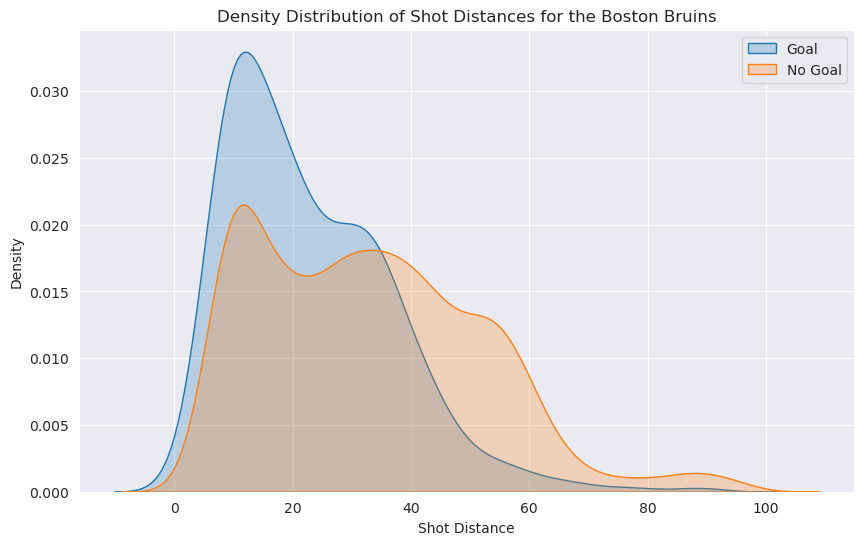

In [496]:
# Create a new column for goal (1) and non-goal (0)
df = team_shots_dfs['Bruins'].copy()
df['isGoal'] = np.where(df['typeDescKey'] == 'shot-on-goal', 0, 1)

# Set up the figure
plt.figure(figsize=(10, 6))

# Plot KDEs for goals and non-goals
sns.kdeplot(df[df['isGoal'] == 1]['shotDistance'], label='Goal', fill=True)
sns.kdeplot(df[df['isGoal'] == 0]['shotDistance'], label='No Goal', fill=True)

# Label the plot
plt.title('Density Distribution of Shot Distances for the Boston Bruins')
plt.xlabel('Shot Distance')
plt.ylabel('Density')
plt.legend()

# Show plot
plt.show()

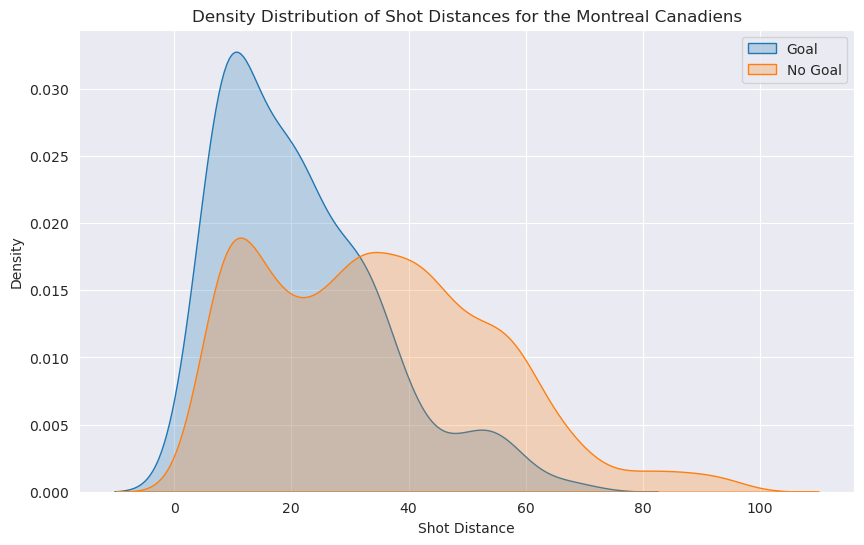

In [497]:
# Create a new column for goal (1) and non-goal (0)
df = team_shots_dfs['Canadiens'].copy()
df['isGoal'] = np.where(df['typeDescKey'] == 'shot-on-goal', 0, 1)

# Set up the figure
plt.figure(figsize=(10, 6))

# Plot KDEs for goals and non-goals
sns.kdeplot(df[df['isGoal'] == 1]['shotDistance'], label='Goal', fill=True)
sns.kdeplot(df[df['isGoal'] == 0]['shotDistance'], label='No Goal', fill=True)

# Label the plot
plt.title('Density Distribution of Shot Distances for the Montreal Canadiens')
plt.xlabel('Shot Distance')
plt.ylabel('Density')
plt.legend()

# Show plot
plt.show()